### Scraping book info with scrapy
This notebook has a scrapy spider for a single page and also a more sophisticated scraper for multiple pages. Scraping takes place on a toyscraping website @ books.toscrap.com

You can only run each scraper once, then the kernel needs to be restarted; to generate output below requires some restarting but NOT clearing of previous data.

In [1]:
#Scraping the first page
import pandas as pd
import re
import scrapy
from scrapy.crawler import CrawlerProcess

In [2]:
class bookspider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "books"
    
    # URL(s) to start with.
    start_urls = ['http://books.toscrape.com/',]

    # Use XPath to parse the response we get.
    def parse(self, response):
        # Iterate over every <li> element in the ol section.
        for li in response.xpath('//div[2]/ol/li'):
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'name': li.xpath('article/h3/a/@title').extract(),
                'price': li.xpath('article/div[2]/p[1]/text()').extract_first(),
                'instock': li.xpath('article/div[2]/p[2]/i/@class').extract(),
                'rating' : li.xpath('article/p/@class').extract()
                  }

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'test1.json',  # Name our storage file.
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(bookspider)
process.start()
print('Success!')

Success!


In [3]:
# Checking whether we got data 
book_df=pd.read_json('test1.json', orient='records')
print(book_df.shape)
print(book_df.head())

(20, 4)
     instock                                     name   price  \
0  [icon-ok]                   [A Light in the Attic]  £51.77   
1  [icon-ok]                     [Tipping the Velvet]  £53.74   
2  [icon-ok]                             [Soumission]  £50.10   
3  [icon-ok]                          [Sharp Objects]  £47.82   
4  [icon-ok]  [Sapiens: A Brief History of Humankind]  £54.23   

                rating  
0  [star-rating Three]  
1    [star-rating One]  
2    [star-rating One]  
3   [star-rating Four]  
4   [star-rating Five]  


### Scrape all pages...

In [2]:
class BookSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "Book"
    
    # URL(s) to start with.
    start_urls = [
        'http://books.toscrape.com/',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <li> element in the ol section.
        for li in response.xpath('//div[2]/ol/li'):            
           
            yield {
                'name': li.xpath('article/h3/a/@title').extract(),
                'price': li.xpath('article/div[2]/p[1]/text()').extract_first(),
                'instock': li.xpath('article/div[2]/p[2]/i/@class').extract(),
                'rating' : li.xpath('article/p/@class').extract()
                   }
        # Get the URL of the previous page.
        next_page = response.xpath('//li[@class="next"]/a/@href').extract_first()
        
        # There are a LOT of pages here.  For our example, we'll just scrape the first 9.
        # This finds the page number. The next segment of code prevents us from going beyond page 9.
        pagenum = int(re.findall(r'\d+',next_page)[0])
        
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None and pagenum < 10:
            next_page = response.urljoin(next_page)
            # Request the next page and recursively parse it the same way we did above
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.          
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'data.json',       # Name our storage file.
    'LOG_ENABLED': False,          # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'Aaron@ABauman',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(BookSpider)
process.start()
print('Success!')

Success!


In [3]:
# Checking whether we got data from all 9 pages
books_df=pd.read_json('data.json', orient='records')
print(books_df.shape)
print(books_df.tail(1))

(180, 4)
       instock            name   price              rating
179  [icon-ok]  [Mrs. Houdini]  £30.25  [star-rating Five]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
books_df.price = [ float(re.sub('[^\d+\.\d+]', '',i)) for i in books_df.price]
rate_keys = {'One': 1,'Two':2,'Three':3,'Four':4,'Five':5}
books_df.rating = [ rate_keys[re.sub('star-rating ','',''.join(i))] for i in books_df.rating]

Text(0.5,1,'Distribution of Book Prices')

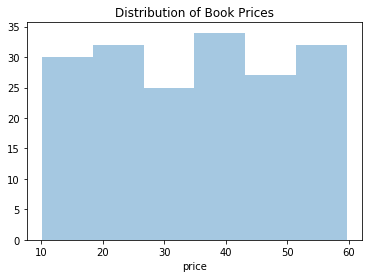

In [6]:
sns.distplot(books_df.price, kde=False)
plt.title('Distribution of Book Prices')

Text(0.5,1,'Distribution of Book Ratings')

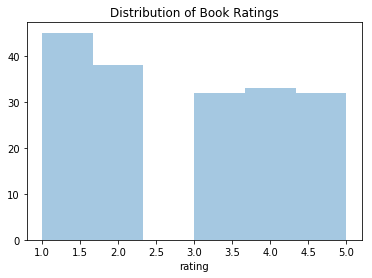

In [7]:
sns.distplot(books_df.rating, kde=False)
plt.title('Distribution of Book Ratings')

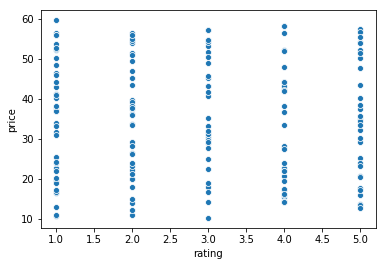

In [8]:
sns.scatterplot(x='rating',y='price',data=books_df)
plt.show()